In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from hmmlearn import hmm
import random
from sklearn.preprocessing import normalize

# 2 Kernel Density Estimation

## 2.2 Task-1:
Implement Kernel Density Estimation (KDE). Your KDE should include the following functions
- allows selection from the following kernels: box, gaussian, triangular
- fit data
- select appropriate bandwidth using the pseudo-likelihood method
- evaluate the density given an input x
- visualize the data and the estimated pdf. For this you can assume that the function will be used only when input dataset is 1-D or 2-D.  

The KDE should support n-dimensional input, so don’t write your code assum-
ing 1-D data.

In [6]:
class KernelDensityEstimation:
    def __init__(self, kernel='gaussian'):
        self.kernel = kernel
        self.bandwidth = None
        self.data = None

    def fit(self, data):
        self.data = np.array(data)
        self.bandwidth = self._select_bandwidth()

    def _select_bandwidth(self):
        n = len(self.data)
        if self.kernel == 'gaussian':
            return 1.06 * np.std(self.data) * n ** (-0.2)
        elif self.kernel == 'box':
            return (4 / 3) * np.std(self.data) * n ** (-0.2)
        elif self.kernel == 'triangular':
            return (6 / 5) * np.std(self.data) * n ** (-0.2)
        else:
            raise ValueError("Invalid kernel type. Choose from 'gaussian', 'box', or 'triangular'.")

    def evaluate_density(self, x):
        if self.data is None:
            raise ValueError("Fit the model with data before evaluating density.")

        x = np.atleast_2d(x)

        if self.kernel == 'gaussian':
            kernel_func = norm.pdf
        elif self.kernel == 'box':
            kernel_func = lambda x: 0.5 * (np.abs(x) <= 1)
        elif self.kernel == 'triangular':
            kernel_func = lambda x: (1 - np.abs(x)) * (np.abs(x) <= 1)

        n = len(self.data)
        density = np.zeros(len(x))

        for i in range(n):
            diff = (x - self.data[i]) / self.bandwidth
            density += kernel_func(diff).prod(axis=1) / (self.bandwidth ** x.shape[1])

        return density / n

    def visualize(self, resolution=100):
        if self.data is None:
            raise ValueError("Fit the model with data before visualizing.")

        if self.data.ndim > 2:
            raise ValueError("Visualization is supported for 1-D or 2-D data only.")

        if self.data.ndim == 1:
            plt.figure(figsize=(10, 6))
            plt.hist(self.data, bins='auto', density=True, alpha=0.5, label='Histogram')

            x_range = np.linspace(min(self.data), max(self.data), resolution)
            density = self.evaluate_density(x_range[:, np.newaxis])  # Ensure x_range has shape (n, 1)
            plt.plot(x_range, density, label='KDE')

            plt.title('Kernel Density Estimation')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.legend()
            plt.show()
        elif self.data.ndim == 2:
            plt.figure(figsize=(10, 6))
            plt.scatter(self.data[:, 0], self.data[:, 1], alpha=0.5, label='Data points')

            x_range = np.linspace(min(self.data[:, 0]), max(self.data[:, 0]), resolution)
            y_range = np.linspace(min(self.data[:, 1]), max(self.data[:, 1]), resolution)
            x_grid, y_grid = np.meshgrid(x_range, y_range)
            xy_values = np.column_stack((x_grid.ravel(), y_grid.ravel()))

            density = self.evaluate_density(xy_values)
            density_grid = density.reshape(resolution, resolution)

            plt.contourf(x_grid, y_grid, density_grid, levels=10, cmap='viridis', label='KDE')

            plt.title('Kernel Density Estimation')
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.legend()
            plt.show()

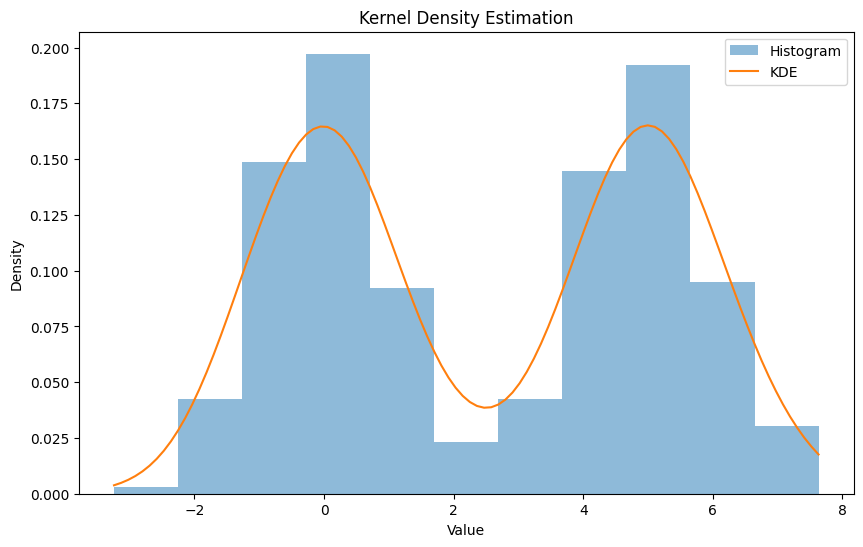

In [7]:
np.random.seed(42)
sample_data = np.concatenate([np.random.normal(0, 1, 500), np.random.normal(5, 1, 500)])

# Create and fit KDE
kde = KernelDensityEstimation(kernel='gaussian')
kde.fit(sample_data)

# Visualize the KDE
kde.visualize()

## 2.3 Task-2:
The next task serves as an extension of Problem 4.2 from Assignment 2 of this course. Datasets remain the same here, as well.   
Recall the bounding box problem from Assignment 2. The task was to determine the optimal horizontal and vertical Euclidean distance thresholds between bounding boxes containing words on a document page. The objective of this task is to establish connections between boxes within a paragraph while ensuring that boxes across paragraphs and columns remain unconnected. Attached are illustrative examples showcasing the desired box connections and a sample visualization of the expected output ATTACHMENT.  
You have also been given the following scripts -
- Script to visualize the enclosing boxes.
- Script to visualize the connecting boxes. The input for this script is a data frame object with the following attributes.
    - ID: The ID number of the word which is in int datatype.
    - Top-Left, Bottom-Right, Top edge center, Bottom edge center, Right edge center, Left edge center: A list containing the x and y coordinates of the respective coordinates as understood by their attribute names.
    - Top box, Bottom box, Right box, Left Box - A list containing the distance and id of the nearest neighbor in the Top, Bottom, Right, and Left directions respectively. HINT - To remove the connection make sure that the list is [-1, 0].

Using the KDE implemented in the previous task, estimate the appropriate horizontal and vertical thresholds to apply to the distances between the boxes, such that boxes within the same paragraphs are connected and there are no connections to boxes in other paragraphs.   
For any 4 images of your choice from the dataset, experiment with different bandwidths . Visualize the density estimated and thresholded document for each of the hyperparameter settings per image.  
Note: If you have 4 hyperparameter configurations, you should have 12 figures for each (2 density estimation curves (horizontal and vertical distances) along with the final output image) for each hyperparameter setting  
Visualize and compare the generated output for the following images given by your KDE with the best hyperparameter configuration with the output obtained from your solution in Assignment 2 Question 4.2. The images are listed below:
- 29.jpg
- 68.jpg
- 145.jpg
- 201.jpg
- 232.jpg
- 250.jpg   

Note : You should visualize the output images side by side for each
test image

In [8]:
# Reading the CSV file
df = pd.read_csv('/content/TLBR_29.csv')

In [9]:
# Creating a new DataFrame to store the transformed data
result_df = pd.DataFrame(columns=['ID', 'Top-Left', 'Bottom-Right', 'Top edge center', 'Bottom edge center', 'Right edge center', 'Left edge center',
                                   'Top box', 'Bottom box', 'Right box', 'Left box'])

In [10]:
# Looping through each row in the original DataFrame
for index, row in df.iterrows():
    word_id = int(row['Id'])

    # Converting coordinates to numeric values
    top_left = list(map(int, row['Top-Left'][1:-1].split(', ')))
    bottom_right = list(map(int, row['Bottom-Right'][1:-1].split(', ')))

    # Calculating edge centers
    top_center = [top_left[0] + (bottom_right[0] - top_left[0]) / 2, top_left[1]]
    bottom_center = [top_left[0] + (bottom_right[0] - top_left[0]) / 2, bottom_right[1]]
    right_center = [bottom_right[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2]
    left_center = [top_left[0], top_left[1] + (bottom_right[1] - top_left[1]) / 2]

    # Initializing distances and neighbor IDs
    top_dist, top_neighbor_id = np.inf, -1
    bottom_dist, bottom_neighbor_id = np.inf, -1
    right_dist, right_neighbor_id = np.inf, -1
    left_dist, left_neighbor_id = np.inf, -1

    # Looping through each row again to find nearest neighbors
    for idx, r in df.iterrows():
        if idx != index:
            neighbor_id = int(r['Id'])

            # Converting coordinates to numeric values
            neighbor_top_left = list(map(int, r['Top-Left'][1:-1].split(', ')))
            neighbor_bottom_right = list(map(int, r['Bottom-Right'][1:-1].split(', ')))

            # Calculating distances
            top_distance = np.linalg.norm(np.array(top_center) - np.array([neighbor_top_left[0] + (neighbor_bottom_right[0] - neighbor_top_left[0]) / 2, neighbor_top_left[1]]))
            bottom_distance = np.linalg.norm(np.array(bottom_center) - np.array([neighbor_top_left[0] + (neighbor_bottom_right[0] - neighbor_top_left[0]) / 2, neighbor_bottom_right[1]]))
            right_distance = np.linalg.norm(np.array(right_center) - np.array([neighbor_bottom_right[0], neighbor_top_left[1] + (neighbor_bottom_right[1] - neighbor_top_left[1]) / 2]))
            left_distance = np.linalg.norm(np.array(left_center) - np.array([neighbor_top_left[0], neighbor_top_left[1] + (neighbor_bottom_right[1] - neighbor_top_left[1]) / 2]))

            # Updating nearest neighbors
            if top_distance < top_dist:
                top_dist, top_neighbor_id = top_distance, neighbor_id
            if bottom_distance < bottom_dist:
                bottom_dist, bottom_neighbor_id = bottom_distance, neighbor_id
            if right_distance < right_dist:
                right_dist, right_neighbor_id = right_distance, neighbor_id
            if left_distance < left_dist:
                left_dist, left_neighbor_id = left_distance, neighbor_id

    # Appending the row to the result DataFrame
    result_df = result_df.append({'ID': word_id, 'Top-Left': top_left, 'Bottom-Right': bottom_right,
                                  'Top edge center': top_center, 'Bottom edge center': bottom_center,
                                  'Right edge center': right_center, 'Left edge center': left_center,
                                  'Top box': [top_dist, top_neighbor_id], 'Bottom box': [bottom_dist, bottom_neighbor_id],
                                  'Right box': [right_dist, right_neighbor_id], 'Left box': [left_dist, left_neighbor_id]},
                                 ignore_index=True)

<ipython-input-10-12056891cc39>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'ID': word_id, 'Top-Left': top_left, 'Bottom-Right': bottom_right,
<ipython-input-10-12056891cc39>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'ID': word_id, 'Top-Left': top_left, 'Bottom-Right': bottom_right,
<ipython-input-10-12056891cc39>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'ID': word_id, 'Top-Left': top_left, 'Bottom-Right': bottom_right,
<ipython-input-10-12056891cc39>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.app

In [11]:
img = cv2.imread('/content/29.jpg')

In [12]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(img_2)

In [13]:
def make_connections(image, euclidean):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left edge center'][0])
      right = int(row['Right edge center'][0])
      top = int(row['Top edge center'][1])
      bottom = int(row['Bottom edge center'][1])
      box_id = int(row['ID'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top box'][1])
      bottom_adjacent_id = int(row['Bottom box'][1])
      left_adjacent_id = int(row['Left box'][1])
      right_adjacent_id = int(row['Right box'][1])

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['ID'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom edge center'][0]) , int(top_adjacent_row['Bottom edge center'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['ID'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top edge center'][0]) , int(bottom_adjacent_row['Top edge center'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['ID'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right edge center'][0]) , int(left_adjacent_row['Right edge center'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['ID'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left edge center'][0]) , int(right_adjacent_row['Left edge center'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

In [25]:
# Choosing images for experimentation
image_paths = ["/content/29.jpg"]
# , "/content/68.jpg", "/content/101.jpg","/content/145.jpg"]

In [15]:
# Displaying the resulting DataFrame
print(result_df.head())

  ID    Top-Left Bottom-Right Top edge center Bottom edge center  \
0  0  [338, 133]   [469, 185]    [403.5, 133]       [403.5, 185]   
1  1  [662, 126]   [795, 178]    [728.5, 126]       [728.5, 178]   
2  2  [822, 133]   [923, 185]    [872.5, 133]       [872.5, 185]   
3  3  [592, 250]   [694, 314]    [643.0, 250]       [643.0, 314]   
4  4  [735, 253]   [846, 308]    [790.5, 253]       [790.5, 308]   

  Right edge center Left edge center                   Top box  \
0      [469, 159.0]     [338, 159.0]  [251.17722826721374, 86]   
1      [795, 152.0]     [662, 152.0]   [141.32586458253138, 4]   
2      [923, 159.0]     [822, 159.0]    [144.1700384962146, 1]   
3      [694, 282.0]     [592, 282.0]  [115.24755962709145, 87]   
4      [846, 280.5]     [735, 280.5]  [104.94879703931818, 88]   

                 Bottom box                 Right box  \
0   [259.9423012901132, 86]    [256.4254277562972, 3]   
1   [144.02777509911067, 4]     [128.191263352851, 2]   
2    [144.1700384962146

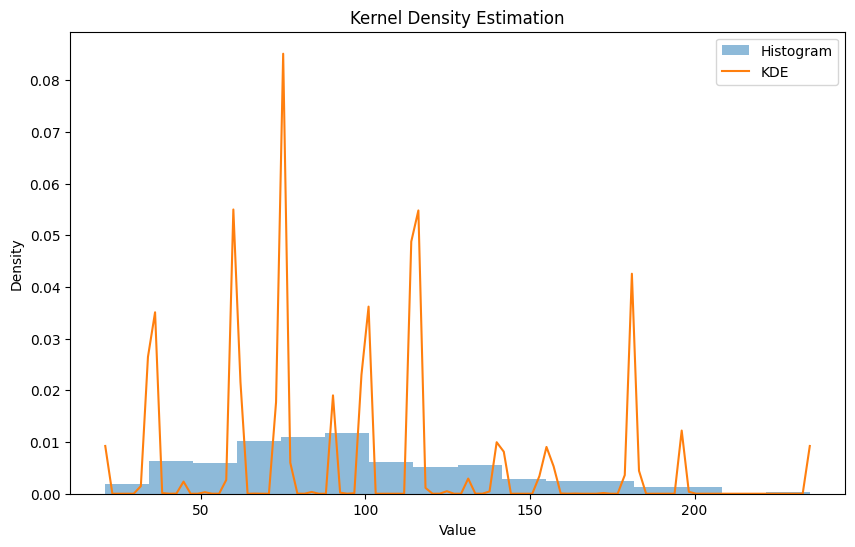

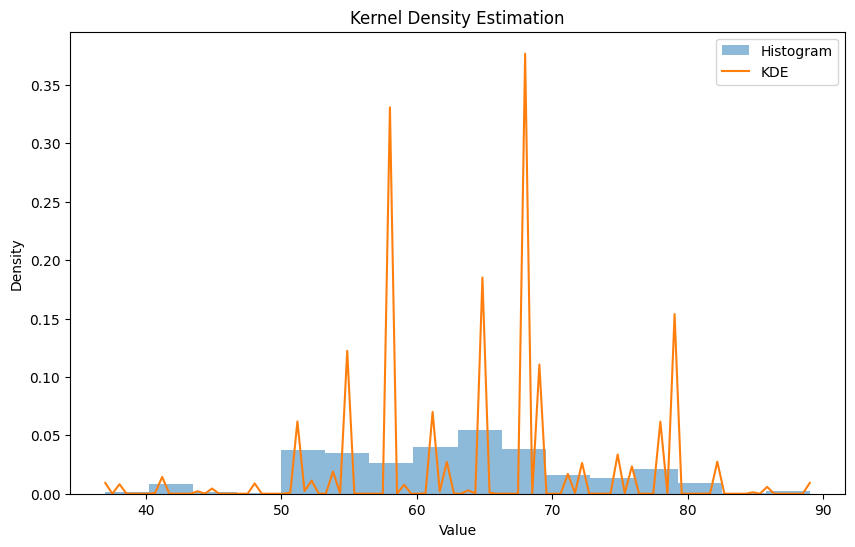

<Figure size 640x480 with 0 Axes>

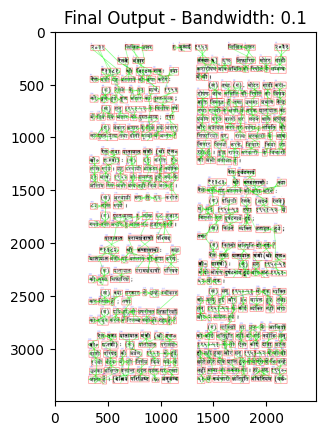

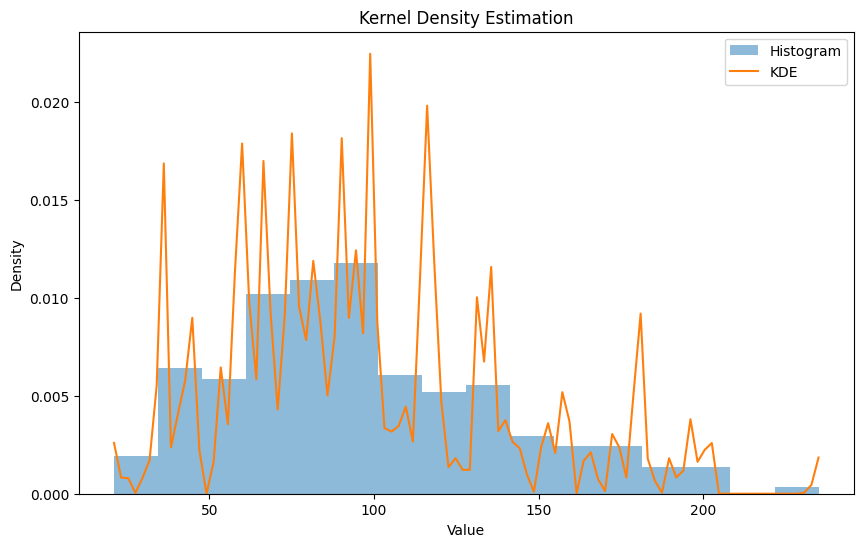

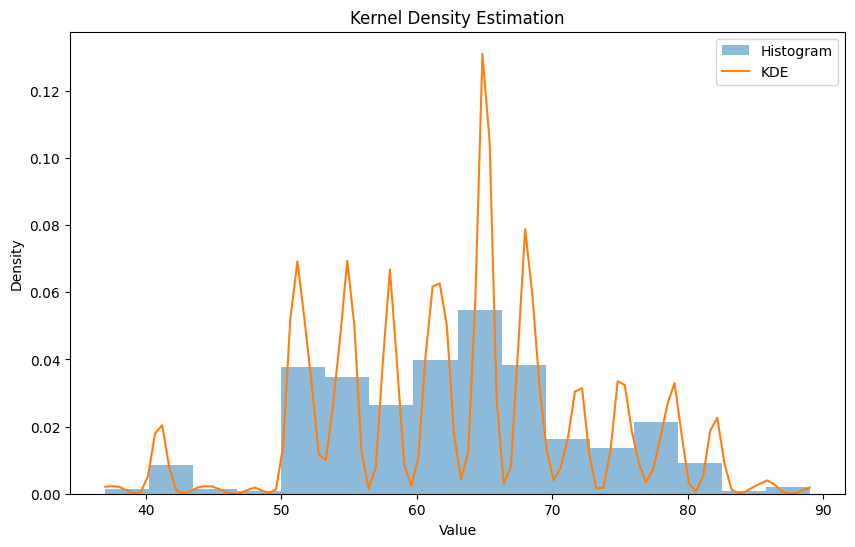

<Figure size 640x480 with 0 Axes>

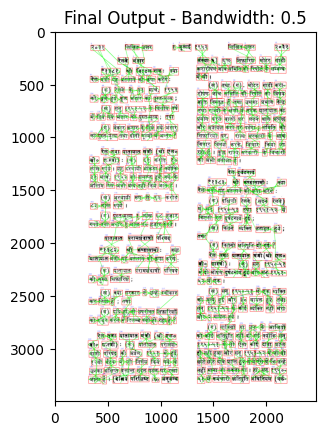

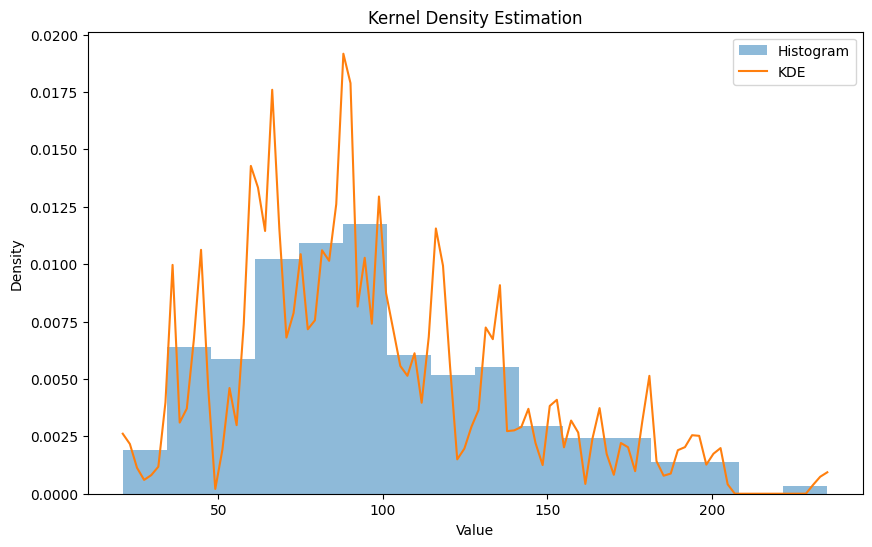

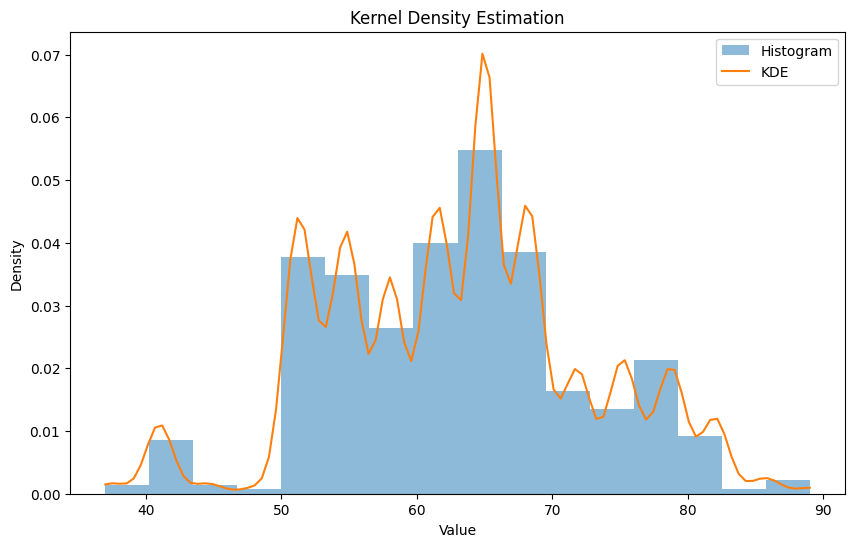

<Figure size 640x480 with 0 Axes>

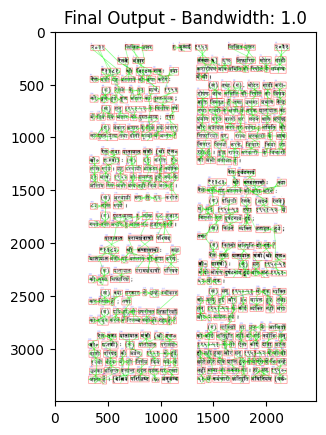

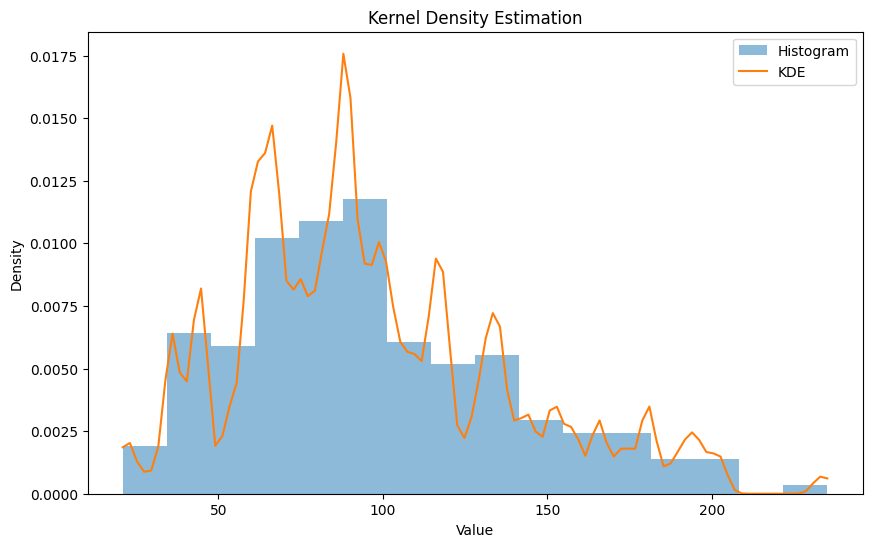

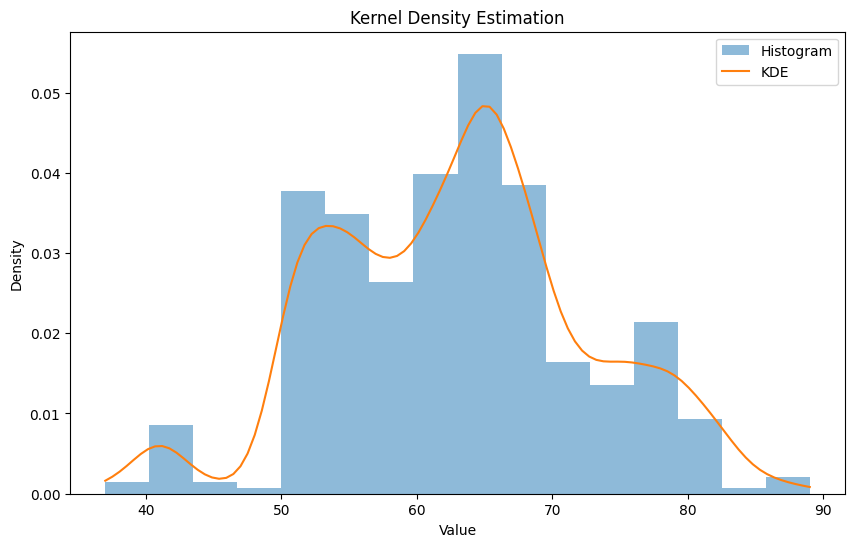

<Figure size 640x480 with 0 Axes>

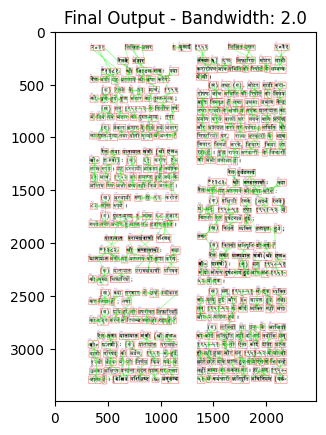

In [31]:
for image_path in image_paths:

    # Reading the image
    img = cv2.imread(image_path)

    # Extracting the necessary columns from the CSV
    data = result_df[['Top-Left', 'Bottom-Right', 'Top edge center', 'Left edge center', 'Bottom edge center', 'Right edge center', 'Top box', 'Bottom box', 'Left box', 'Right box']]

    # Create and fit KDE for horizontal distances
    kde_horizontal = KernelDensityEstimation(kernel='gaussian')
    horizontal_data = np.array([coord[0] for coord in data['Right edge center']]) - np.array([coord[0] for coord in data['Left edge center']])
    kde_horizontal.fit(horizontal_data)

    # Create and fit KDE for vertical distances
    kde_vertical = KernelDensityEstimation(kernel='gaussian')
    vertical_data = np.array([coord[1] for coord in data['Bottom edge center']]) - np.array([coord[1] for coord in data['Top edge center']])
    kde_vertical.fit(vertical_data)

    # Experimenting with different bandwidths
    bandwidths = [0.1, 0.5, 1.0, 2.0]

    for bandwidth in bandwidths:

        # Setting bandwidth for both KDEs
        kde_horizontal.bandwidth = bandwidth
        kde_vertical.bandwidth = bandwidth

        # Visualizing KDEs
        kde_horizontal.visualize()
        kde_vertical.visualize()
        plt.tight_layout()
        plt.show()

        # Appling thresholds and visualize connections
        horizontal_threshold = kde_horizontal.bandwidth
        vertical_threshold = kde_vertical.bandwidth

        # Appling the thresholds and obtain the final output
        euclidean = result_df.copy()

        # Visualizing bounding boxes and connections
        image_with_connections = make_connections(img, euclidean)
        plt.imshow(image_with_connections)
        plt.title(f'Final Output - Bandwidth: {bandwidth}')
        plt.show()

# **Hidden Markov Models**

## **Task-3**

### 3.4.2

In [ ]:
rolls = np.load('rolls.npy')

In [ ]:
rolls, rolls.shape


(array([[2],
        [0],
        [3],
        ...,
        [1],
        [3],
        [5]], dtype=int64),
 (50000, 1))

In [ ]:
rolls = rolls.ravel()
rolls.shape

(50000,)

In [ ]:
train_data = rolls[:25000]
test_data = rolls[25000:]

In [ ]:
best_score = best_model = None
n_fits = 100
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.CategoricalHMM(
        n_components=2, random_state=idx,
        init_params='te')

    model.startprob_ = np.array([1.0, 0.0])
    model.fit(train_data.reshape(-1, 1))
    score = model.score(test_data.reshape(-1, 1))
    print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Best score: {best_score}')

Model #0	Score: -43182.921526451246
Model #1	Score: -43174.51160366358
Model #2	Score: -43186.57318390851
Model #3	Score: -43190.351480900514
Model #4	Score: -43218.41729209722
Model #5	Score: -43173.61340889598
Model #6	Score: -43179.36235406709
Model #7	Score: -43192.935335172115
Model #8	Score: -43133.877107262146
Model #9	Score: -43191.177737700185
Model #10	Score: -43191.159801818794
Model #11	Score: -43100.49063394331
Model #12	Score: -43181.852339474644
Model #13	Score: -43182.39635128467
Model #14	Score: -43158.100610043555
Model #15	Score: -43154.593715807234
Model #16	Score: -43210.4601082571
Model #17	Score: -43167.25480661555
Model #18	Score: -43199.69356172092
Model #19	Score: -43190.45065725117
Model #20	Score: -43182.39405502736
Model #21	Score: -43224.657213090824
Model #22	Score: -43185.15941425831
Model #23	Score: -43217.13724767122
Model #24	Score: -43142.671173391886
Model #25	Score: -43176.73418607311
Model #26	Score: -43186.85505588137
Model #27	Score: -43181.3402

In [ ]:
states = best_model.predict(test_data.reshape(-1, 1))

In [ ]:
states

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

C:\Users\Ishan\AppData\Local\Temp\ipykernel_25076\854980918.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


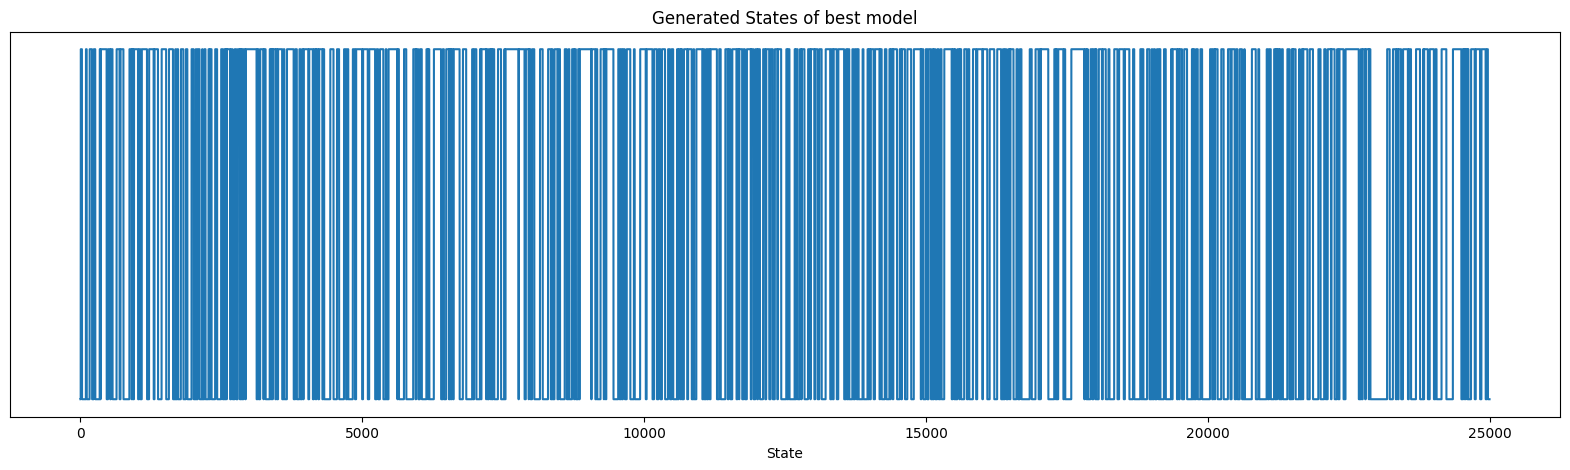

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(states)
ax.set_yticks([])
ax.set_title('Generated States of best model')
ax.set_xlabel('Time (# rolls)')
ax.set_xlabel('State')
fig.show()

In [ ]:
trans_mat = best_model.transmat_.round(3)
print("Transition Matrix of the best model: \n", trans_mat)

Transition Matrix of the best model: 
 [[0.86  0.14 ]
 [0.133 0.867]]


From the above transition matrix we see that probability of going from a loaded die to loaded die is 0.86 and going from loaded die to fair die is 0.14<br>
We also see that probability of going from a fair die to loaded die is 0.133 and going from fair die to fair die is 0.867<br>
The above problem HMM corresonds to the <HERE> question of HMM.

### 3.4.4

In [ ]:
emission_probab = best_model.emissionprob_.round(3)
print("Emission Probability of the best model: \n", emission_probab)

Emission Probability of the best model: 
 [[0.117 0.123 0.11  0.096 0.107 0.448]
 [0.158 0.151 0.165 0.174 0.171 0.179]]


We see that the emission probability of the fair die comes out to be almost equal for each observed state. This was expected since it is a fair die. On the other hand we see that the emission probabilities of the loaded die are unequal. From the above data, we can see that the loaded die is biased towards getting a roll of number 6. This is becuase the roll number 6 has the emission probability of 0.448.<br>
The following problem in HMM corresponds to the Learning question in HMM.

## **Task-4**

In [ ]:
runs = np.load('runs.npy')

In [ ]:
runs.shape, runs

((30000, 1),
 array([[1],
        [6],
        [4],
        ...,
        [1],
        [6],
        [3]], dtype=int64))

In [ ]:
train_data_runs = runs[:20000]
test_data_runs = runs[10000:]

In [ ]:
def get_virat():
    random_numbers = [random.uniform(0, 1) for _ in range(6)]
    random_numbers[1] += 0.5
    random_numbers[2] += 0.5

    random_numbers.append(0)
    random_numbers[-1], random_numbers[-2] = random_numbers[-2], random_numbers[-1]

    # Normalize the list
    normalized_numbers = normalize([random_numbers], norm='l1')
    return normalized_numbers[0]


def get_rohit():
    random_numbers = [random.uniform(0, 1) for _ in range(6)]
    random_numbers[3] += 1.5
    random_numbers[4] += 1.5
    random_numbers[5] += 1.5

    random_numbers.append(0)
    random_numbers[-1], random_numbers[-2] = random_numbers[-2], random_numbers[-1]

    # Normalize the list
    normalized_numbers = normalize([random_numbers], norm='l1')
    return normalized_numbers[0]



In [ ]:
best_score = best_model = None
n_fits = 100
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.CategoricalHMM(
        n_components=2,
        init_params='s', algorithm='viterbi', random_state=idx)

    #roughly 30 percent chance (you don’t know the exact percentage) of strike changes at the end of each ball.
    random_number = random.uniform(0.25, 0.35)
    model.transmat_ = [[1-random_number, random_number], [random_number, 1-random_number]]

    #Virat is likely to focus on singles and doubles
    #to anchor the innings. In contrast, Rohit is more prone to taking risky shots to
    #boost the run rate.
    model.emissionprob_ = np.array([get_virat(), get_rohit()])

    model.fit(train_data_runs)
    score = model.score(test_data_runs)
    print(f'Model #{idx}\tScore: {score}')
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

print(f'Best score: {best_score}')

Model #0	Score: -33981.76894687046
Model #1	Score: -33980.33887405763
Model #2	Score: -33980.40390933035
Model #3	Score: -33984.2895792689
Model #4	Score: -33985.95668707133
Model #5	Score: -34016.80265809157
Model #6	Score: -34029.55057528211
Model #7	Score: -34010.54337528278
Model #8	Score: -33989.49756649799
Model #9	Score: -34006.31480564788
Model #10	Score: -33985.279720384904
Model #11	Score: -34008.14628030607
Model #12	Score: -33999.31880829185
Model #13	Score: -33982.532699328316
Model #14	Score: -34002.42215839065
Model #15	Score: -34009.594639108036
Model #16	Score: -33988.376733582074
Model #17	Score: -34004.685407345445
Model #18	Score: -33989.12837726345
Model #19	Score: -33992.21129078934
Model #20	Score: -34000.12037371488
Model #21	Score: -33999.24338938868
Model #22	Score: -33996.17939023329
Model #23	Score: -34007.73421045734
Model #24	Score: -33987.53904947901
Model #25	Score: -33987.00739212243
Model #26	Score: -34020.44062441475
Model #27	Score: -34007.2560904900

In [ ]:
best_model.startprob_.round(3)

array([1., 0.])

In [ ]:
best_model.transmat_.round(3)

array([[0.574, 0.426],
       [0.328, 0.672]])

In [ ]:
best_model.emissionprob_.round(3)

array([[0.174, 0.347, 0.289, 0.042, 0.048, 0.   , 0.1  ],
       [0.088, 0.083, 0.091, 0.053, 0.413, 0.   , 0.272]])

In [ ]:
hidden_states_sequence = best_model.predict(runs.reshape(-1, 1))

# Extract information about who played the first and last ball
first_ball_player = "Virat" if hidden_states_sequence[0] == 0 else "Rohit"
last_ball_player = "Virat" if hidden_states_sequence[-1] == 0 else "Rohit"

print("First ball was played by: ", first_ball_player)
print("Last ball was played by: ", last_ball_player)

First ball was played by:  Virat
Last ball was played by:  Rohit
